In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import datetime 
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
#import shap
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data_for_data_analytics_2.csv')
df.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916.0,103916.0,30-34,M,15,17,17,7350,1,1.43,2,1
1,708749,17/08/2017,17/08/2017,916.0,103917.0,30-34,M,16,19,21,17861,2,1.82,2,0
2,708771,17/08/2017,17/08/2017,916.0,103920.0,30-34,M,20,25,22,693,0,0.00,1,0
3,708815,30/08/2017,30/08/2017,916.0,103928.0,30-34,M,28,32,32,4259,1,1.25,1,0
4,708818,17/08/2017,17/08/2017,916.0,103928.0,30-34,M,28,33,32,4133,1,1.29,1,1


# 1. Data cleaning

In [3]:
# All the campaign duration are less than one day. So assuming it's launched by a day to day basis
df.reporting_start = pd.to_datetime(df.reporting_start)
df.reporting_end = pd.to_datetime(df.reporting_end)

# Check out any difference in weekdays
df['day_of_week'] = df['reporting_start'].dt.day_name()
df.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,day_of_week
0,708746,2017-08-17,2017-08-17,916.0,103916.0,30-34,M,15,17,17,7350,1,1.43,2,1,Thursday
1,708749,2017-08-17,2017-08-17,916.0,103917.0,30-34,M,16,19,21,17861,2,1.82,2,0,Thursday
2,708771,2017-08-17,2017-08-17,916.0,103920.0,30-34,M,20,25,22,693,0,0.00,1,0,Thursday
3,708815,2017-08-30,2017-08-30,916.0,103928.0,30-34,M,28,32,32,4259,1,1.25,1,0,Wednesday
4,708818,2017-08-17,2017-08-17,916.0,103928.0,30-34,M,28,33,32,4133,1,1.29,1,1,Thursday


In [4]:
def check_nan(df):
    miss=df.isnull().sum()/len(df)
    miss=miss[miss>0]
    miss.sort_values(inplace=True)
    return miss

def get_oh_df(dataframe, factor_list):
    for factor in factor_list:
        dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[factor])], axis = 1) 
        dataframe = dataframe.drop(factor, axis = 1)

    return dataframe

def plot_dist(target):
    sns.set()
    target = target.dropna()
    sns.histplot(target)
    
    # Get the fitted parameters used by the function
    (mu, sigma) = ss.norm.fit(target)

    # Dist plot
    plt.title("Distibution plot", fontsize=12)
    plt.legend([f'Normal dist. ($\mu=$ {round(mu,2)} and $\sigma=$ {round(sigma,2)})'], loc='best')
    plt.ylabel('Frequency')

In [5]:
check_nan(df)

campaign_id       0.334208
fb_campaign_id    0.334208
dtype: float64

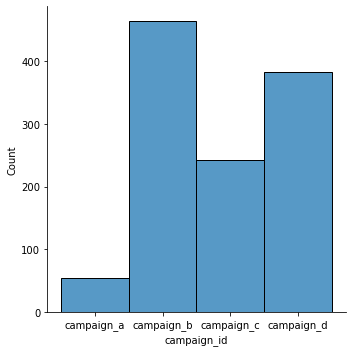

In [6]:
# Replace campaing id to campaign a,b,c,d

df["campaign_id"].replace({916:"campaign_a",936:"campaign_b",1178:"campaign_c"}, inplace=True)
df["campaign_id"] = df["campaign_id"].fillna('campaign_d')
df.campaign_id.unique()
sns.displot(data=df, x="campaign_id")

# 2. Campaign overall analysis

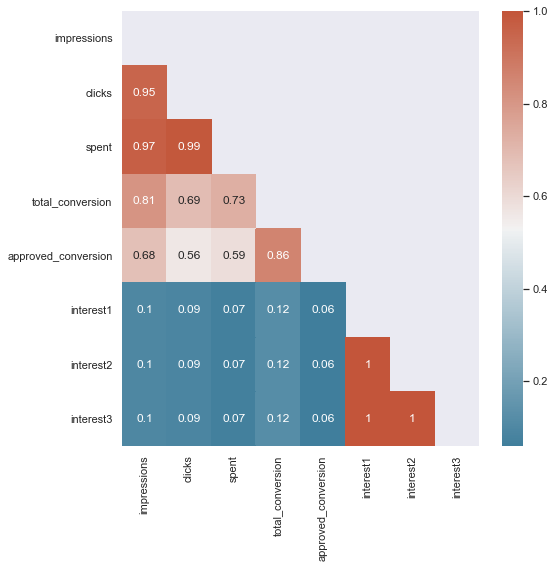

In [7]:
# Correlation analysis 

checks = ['impressions', 'clicks', 'spent', 'total_conversion','approved_conversion', 
          'interest1', 'interest2', 'interest3']

corr = round(df[checks].corr(),2)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(8, 8))
sns.set(font_scale=1)
sns.heatmap(corr, annot=True, 
            cmap = cmap, mask = mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()

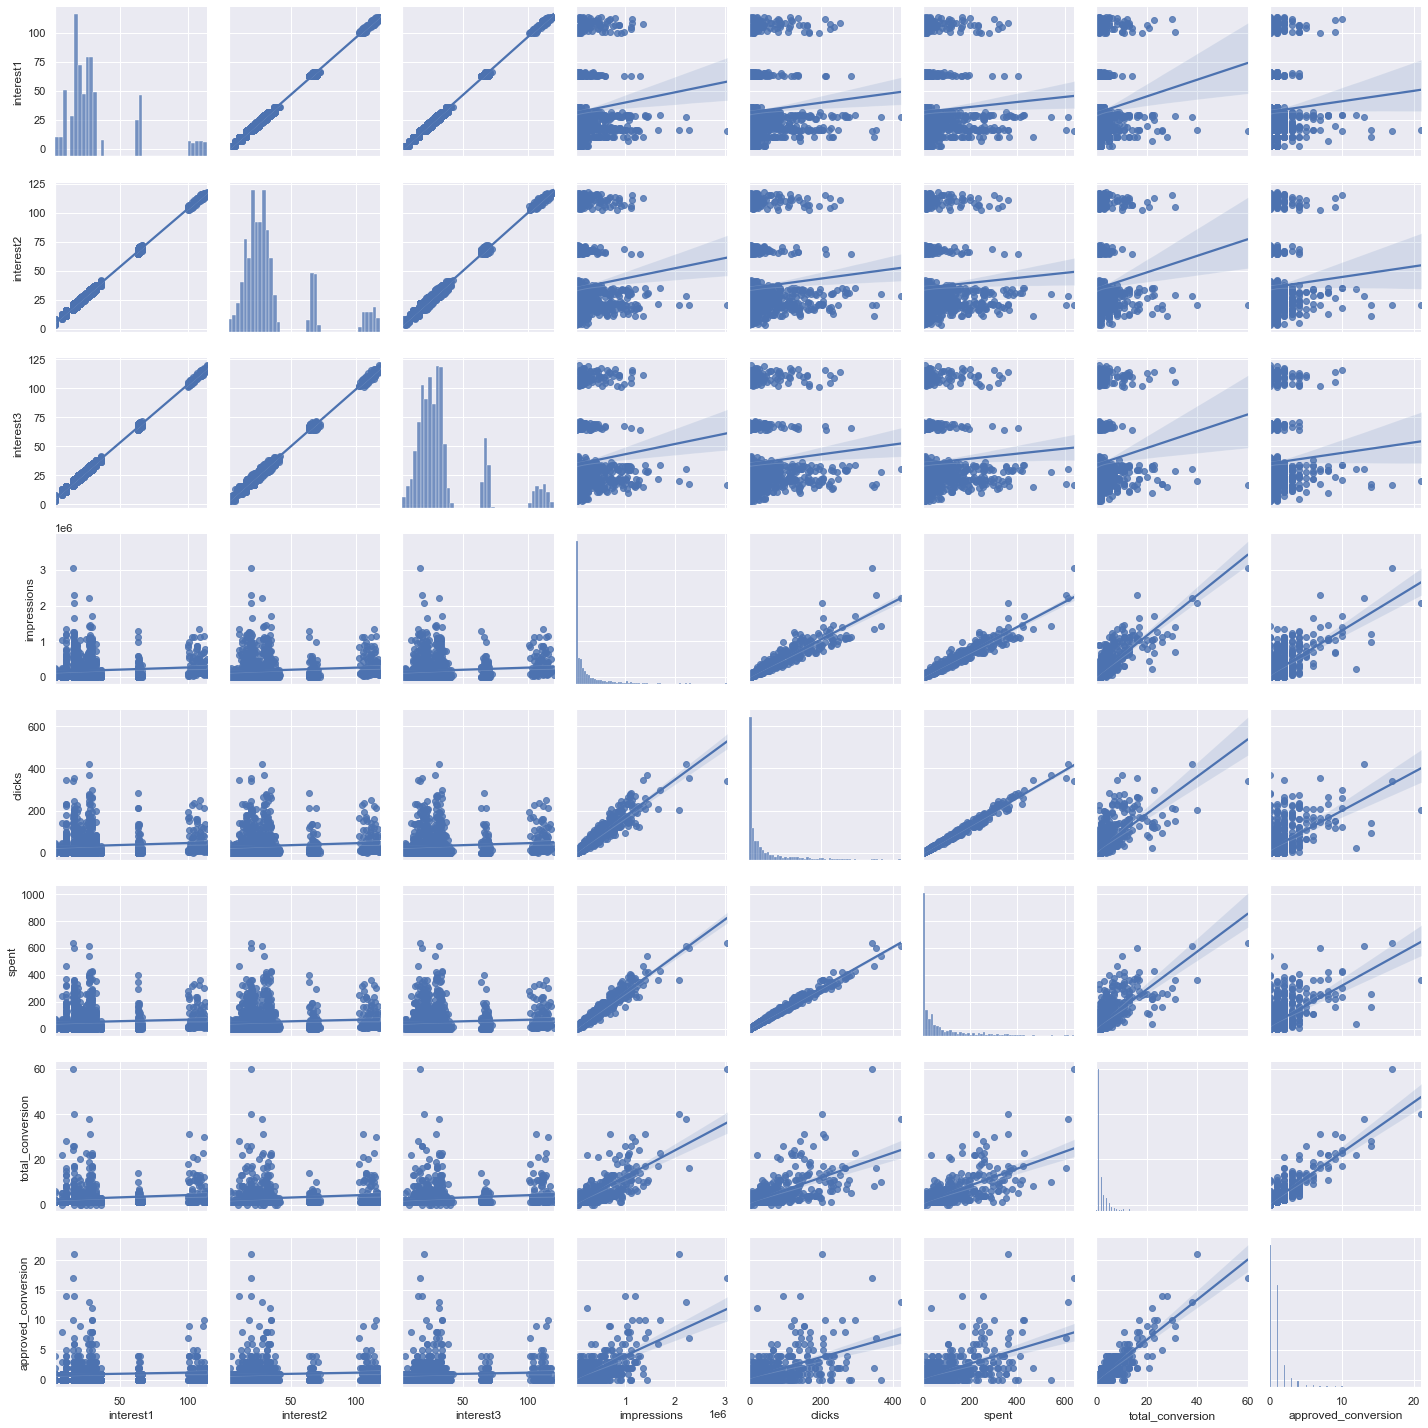

In [8]:
# Insepct data distribution in numerical 

num_features_specefic = ['interest1', 'interest2', 'interest3', 'impressions', 'clicks', 'spent', 'total_conversion', 'approved_conversion']
sns.pairplot(df[num_features_specefic], kind="reg")

plt.tight_layout()

Text(0.5, 0, 'Ads Display Time')

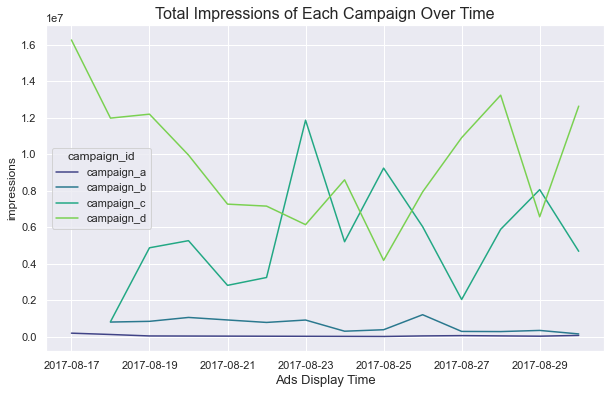

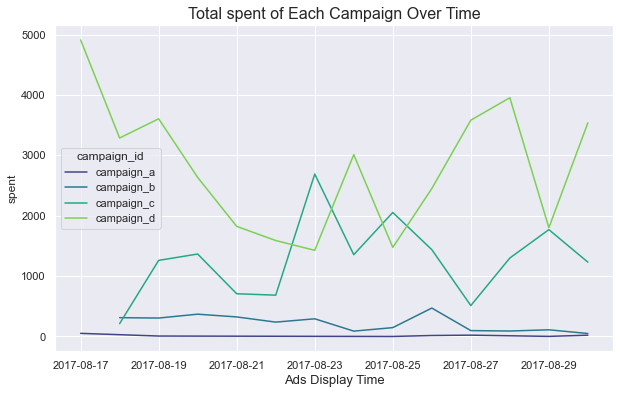

In [9]:
# Check total impressions over time 

camp_day = df.groupby(['campaign_id', 'reporting_start']).sum().reset_index()
ax = plt.figure(figsize=(10, 6))
ax = sns.lineplot(data = camp_day, x = 'reporting_start', y = 'impressions', hue = 'campaign_id', palette = 'viridis')
ax.set_title('Total Impressions of Each Campaign Over Time', fontsize=16)
ax.set_xlabel('Ads Display Time', fontsize=13)

camp_day = df.groupby(['campaign_id', 'reporting_start']).sum().reset_index()
ax = plt.figure(figsize=(10, 6))
ax = sns.lineplot(data = camp_day, x = 'reporting_start', y = 'spent', hue = 'campaign_id', palette = 'viridis')
ax.set_title('Total spent of Each Campaign Over Time', fontsize=16)
ax.set_xlabel('Ads Display Time', fontsize=13)

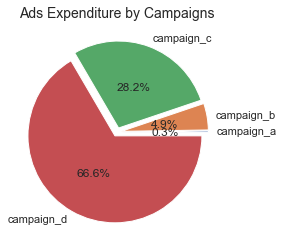

In [10]:
data = df.groupby(['campaign_id']).sum().spent

pie, ax = plt.subplots(figsize=[4,4])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Ads Expenditure by Campaigns", fontsize=14);

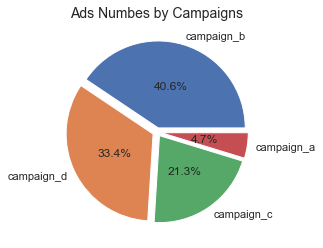

In [11]:
data = df.campaign_id.value_counts()

pie, ax = plt.subplots(figsize=[4,4])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Ads Numbes by Campaigns", fontsize=14);

# 1. Assess overall campaigns performance

In [12]:
def get_metrics(dataframe):
    dataframe = dataframe[(dataframe['clicks'] != 0) & (dataframe['approved_conversion'] != 0)]
    dataframe['cpm'] = dataframe['spent']*1000/dataframe['impressions']
    dataframe['ctr'] = (dataframe['clicks']/dataframe['impressions'])*100
    dataframe['cvr'] = (dataframe['approved_conversion']/dataframe['clicks'])*100
    
    dataframe['cpm'] = dataframe['spent']*1000/dataframe['impressions']
    dataframe['cpc'] = dataframe['spent']/dataframe['clicks']
    dataframe['cpa'] = dataframe['spent']/dataframe['approved_conversion']
    return dataframe

def plot_four(df, factor, w, h):
    metrics = ['ctr', 'cvr', 'cpc', 'cpa']
    for metric in metrics:
        ax = plt.figure(figsize=[w, h])
        if factor == 'day_of_week':
            ax = sns.barplot(data = df, x = 'day_of_week', y = metric , 
                     order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
        else:
            ax = sns.barplot(data = df, x= factor, y=metric)
        for p in ax.patches:
            ax.annotate(f'{round(p.get_height(),3)}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        plt.title(f'Average {metric.upper()} in {factor.upper()}', fontsize=14)
#        plt.xlabel("campaign_id", fontsize=13)
#        plt.ylabel("campaign_id", fontsize=13)
        plt.tight_layout()
        plt.show()
        
        
def plot_factor_count(df, camp_name, factor):
    counts = pd.DataFrame(df[df['campaign_id'] == camp_name][factor].value_counts()).reset_index()

    if factor == 'day_of_week':
        ax = sns.barplot(data = counts, x = 'index', y = factor, 
                     order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
    else:
        ax = sns.barplot(data = counts, x = 'index', y = factor)
        
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

    plt.title(f'Counts of {factor.upper()} in {camp_name.upper()}', fontsize = 14)
    plt.ylabel('Counts')
    plt.xlabel(f'{factor.upper()}')
    plt.show()

In [13]:
campaign = df.groupby(['campaign_id']).sum().reset_index()
campaign = get_metrics(campaign)
campaign.head()

,campaign_id,ad_id,fb_campaign_id,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,cpm,ctr,cvr,cpc,cpa
0,campaign_a,38333977,5621757.0,1187,1397,1363,482925,113,149.710001,58,24,0.310007,0.023399,21.238938,1.324867,6.237917
1,campaign_b,370765340,53545736.0,11622,13239,13252,8128187,1984,2893.369999,537,183,0.355967,0.024409,9.223790,1.458352,15.810765
2,campaign_c,272481867,35131868.0,6576,7416,7442,69902476,9577,16577.159998,1050,378,0.237147,0.013701,3.946956,1.730935,43.854921
3,campaign_d,446858288,0.0,18067,19377,19345,134921240,26491,39084.989961,1619,494,0.289687,0.019634,1.864784,1.475406,79.119413


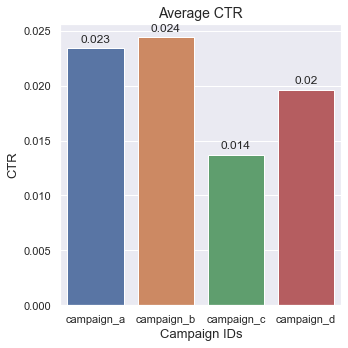

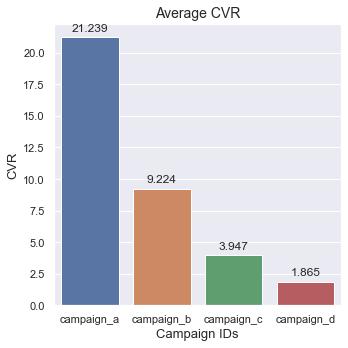

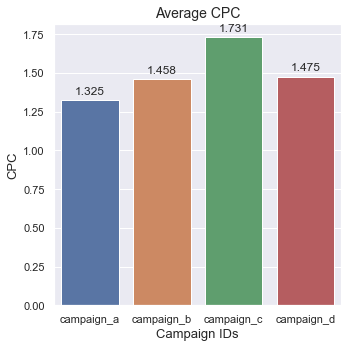

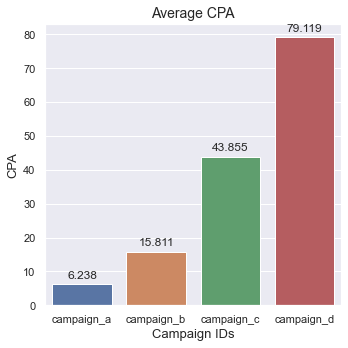

In [14]:
# Plot the 4 metrics with 4 campaigns

metrics = ['ctr', 'cvr', 'cpc', 'cpa']
for metric in metrics:
    fig = plt.figure(figsize=(5, 5))
    ax = sns.barplot(data = campaign, x="campaign_id", y=metric)
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),3)}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    plt.title(f'Average {metric.upper()}', fontsize=14)
    plt.xlabel("Campaign IDs", fontsize=13)
    plt.ylabel(f"{metric.upper()}", fontsize=13)
    plt.tight_layout()
    plt.show()

In [15]:
# CTR: Chi-square test contingency table to test for independence 

campaign['non_clicks'] = campaign['impressions'] - campaign['clicks']
con_ctr = campaign[['campaign_id', 'clicks', 'non_clicks']].set_index('campaign_id')
stat, p, dof, expected = stats.chi2_contingency(con_ctr)
print(f'p-value:{p}')

p-value:6.409965258294786e-242


In [16]:
# CVR: Chi-square test contingency table to test for independence

campaign['non_conversion'] = campaign['clicks'] - campaign['approved_conversion']
con_cvr = campaign[['campaign_id', 'approved_conversion', 'non_conversion']].set_index('campaign_id')
stat, p, dof, expected = stats.chi2_contingency(con_cvr)
print(f'p-value:{p}')

p-value:8.960270644463005e-123


In [17]:
campaign_day = df.groupby(['campaign_id', 'reporting_start']).sum().reset_index()
campaign_day = campaign_day[(campaign_day['clicks'] != 0) & (campaign_day['approved_conversion'] != 0)]
campaign_day = get_metrics(campaign_day)
campaign_day.head()

,campaign_id,reporting_start,ad_id,fb_campaign_id,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,cpm,ctr,cvr,cpc,cpa
0,campaign_a,2017-08-17,11351362,1664564.0,307,367,356,182908,39,51.58,18,8,0.282000,0.021322,20.512821,1.322564,6.4475
1,campaign_a,2017-08-18,7808352,1145101.0,194,238,236,110621,22,29.58,11,6,0.267400,0.019888,27.272727,1.344545,4.9300
2,campaign_a,2017-08-19,1419370,208146.0,32,40,41,30089,6,7.21,2,1,0.239622,0.019941,16.666667,1.201667,7.2100
5,campaign_a,2017-08-27,4267369,625980.0,126,153,140,48387,16,21.91,7,4,0.452808,0.033067,25.000000,1.369375,5.4775
7,campaign_a,2017-08-30,6381517,935713.0,227,261,255,59877,17,21.58,10,4,0.360406,0.028392,23.529412,1.269412,5.3950


In [18]:
# Applye ANOVA test for CPC. Aggregated on daily basis 

cpc_a = campaign_day[campaign_day['campaign_id'] == 'campaign_a'].cpc
cpc_b = campaign_day[campaign_day['campaign_id'] == 'campaign_b'].cpc
cpc_c = campaign_day[campaign_day['campaign_id'] == 'campaign_c'].cpc
cpc_d = campaign_day[campaign_day['campaign_id'] == 'campaign_d'].cpc

fvalue, pvalue = stats.f_oneway(cpc_a, cpc_b, cpc_c, cpc_d)
print(fvalue, pvalue)

98.87482678684832 8.290851758925585e-19


In [19]:
# Applye ANOVA test for CPA. Aggregated on daily basis 

cpa_a = campaign_day[campaign_day['campaign_id'] == 'campaign_a'].cpa
cpa_b = campaign_day[campaign_day['campaign_id'] == 'campaign_b'].cpa
cpa_c = campaign_day[campaign_day['campaign_id'] == 'campaign_c'].cpa
cpa_d = campaign_day[campaign_day['campaign_id'] == 'campaign_d'].cpa

fvalue, pvalue = stats.f_oneway(cpa_a, cpa_b, cpa_c, cpa_d)
print(fvalue, pvalue)

22.06283115829006 1.1524663901394004e-08


## 2.1 Analyze campaign A

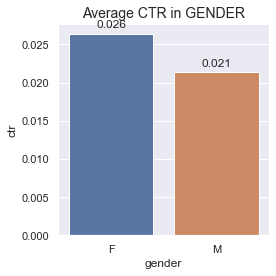

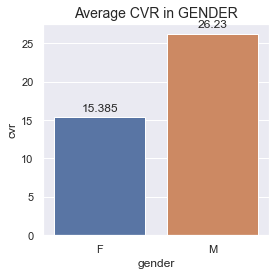

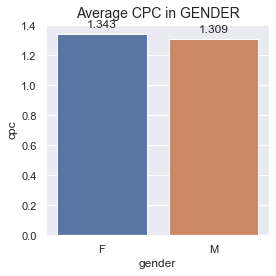

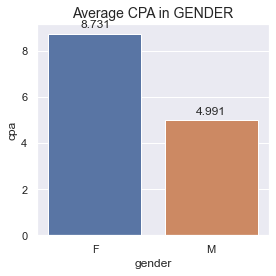

In [20]:
a_gender = df[df['campaign_id'] == 'campaign_a'].groupby(['gender']).sum().reset_index()
a_gender = get_metrics(a_gender)

plot_four(a_gender, 'gender', 4, 4)

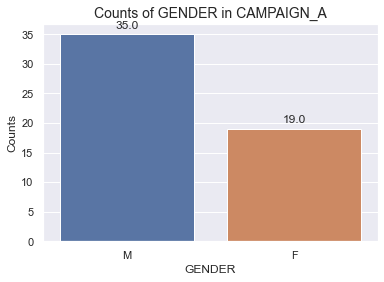

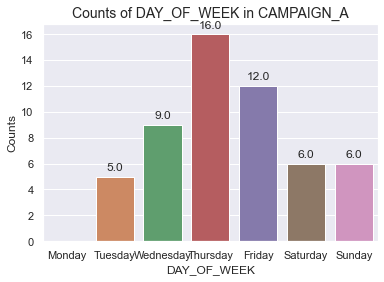

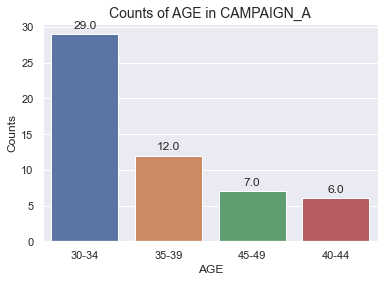

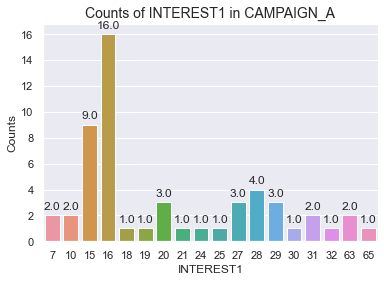

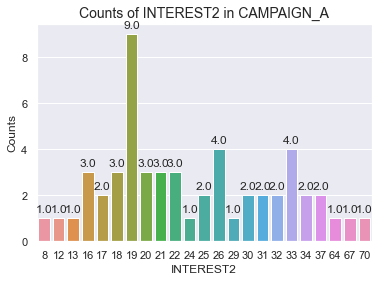

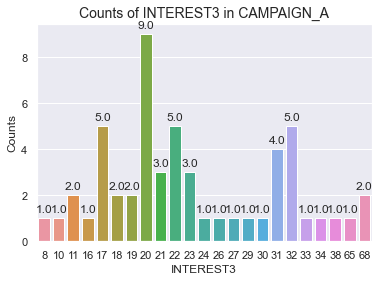

In [21]:
factors = ['gender', 'day_of_week', 'age', 'interest1', 'interest2', 'interest3']
for f in factors:
    plot_factor_count(df, 'campaign_a', f)

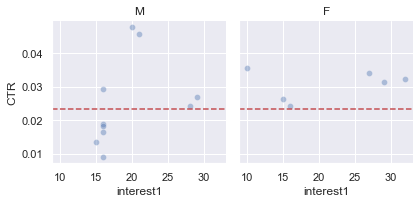

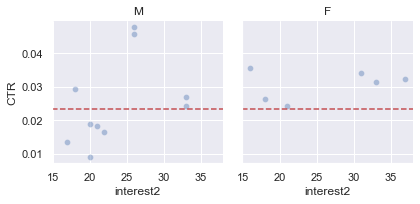

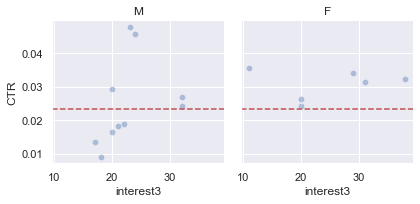

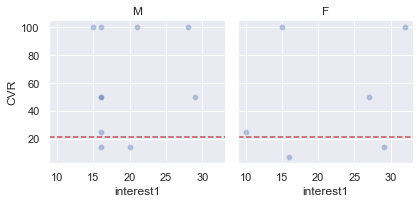

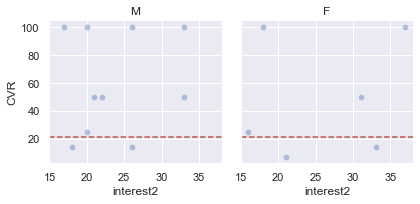

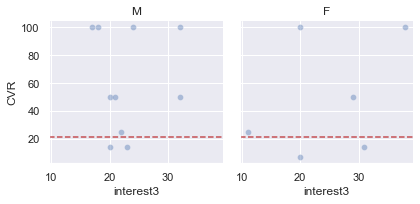

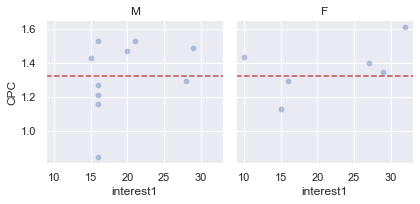

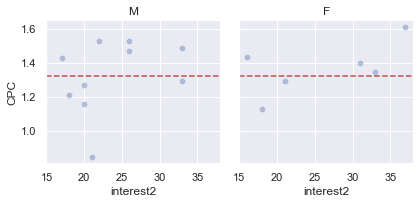

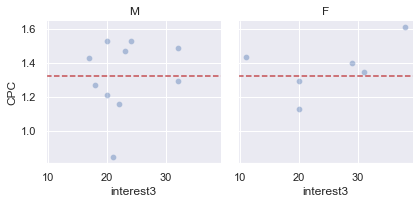

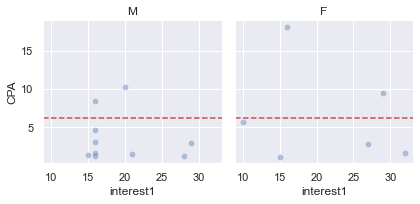

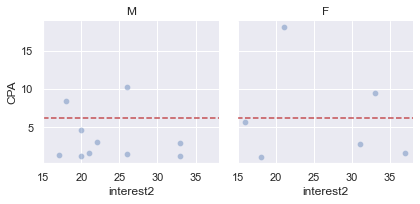

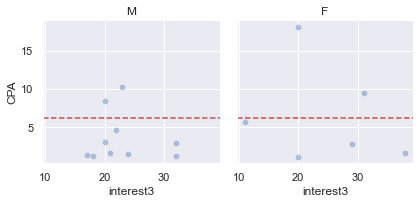

In [22]:
df_a = df[df['campaign_id'] == 'campaign_a']
df_a = get_metrics(df_a)
camp_a = campaign[campaign['campaign_id'] == 'campaign_a']

metrics = ['ctr', 'cvr', 'cpc', 'cpa']
interests = ['interest1', 'interest2', 'interest3']

for metric in metrics:
    for i in interests:
        g = sns.FacetGrid(df_a, col = 'gender')
        g.map(sns.scatterplot, i, metric,  alpha=.4)
        g.map(plt.axhline, y= camp_a[metric][0], color='r', linestyle='--')
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        g.set_axis_labels(i, f'{metric.upper()}')
        g.tight_layout()

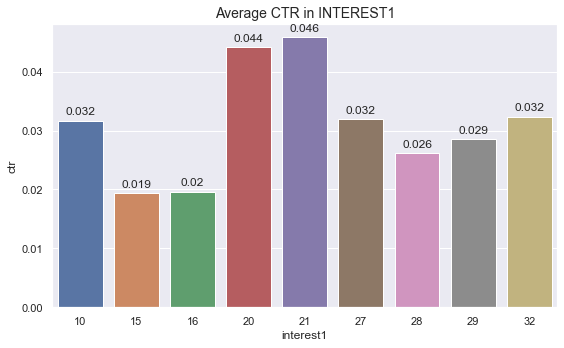

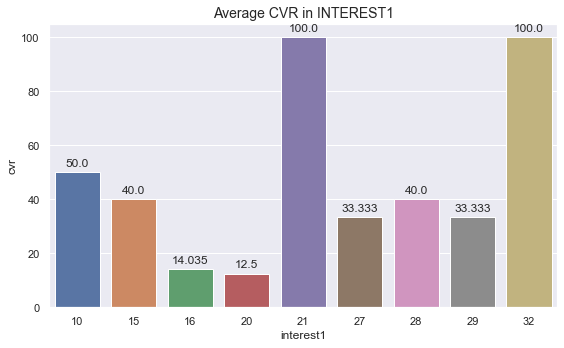

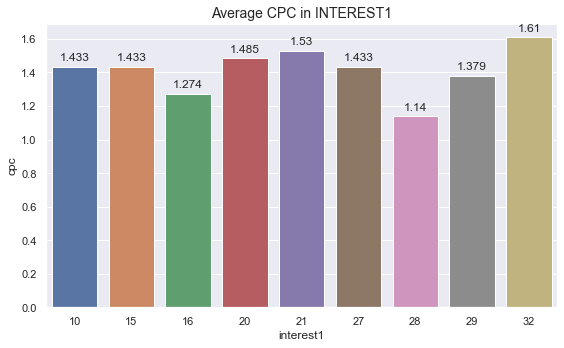

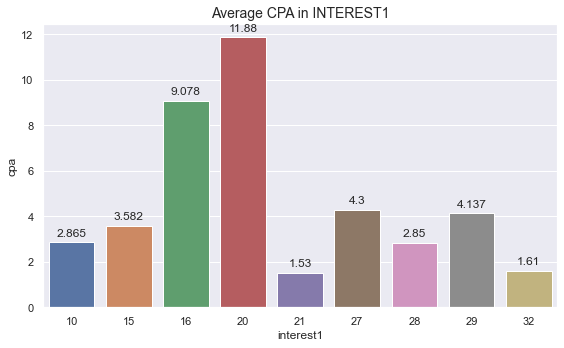

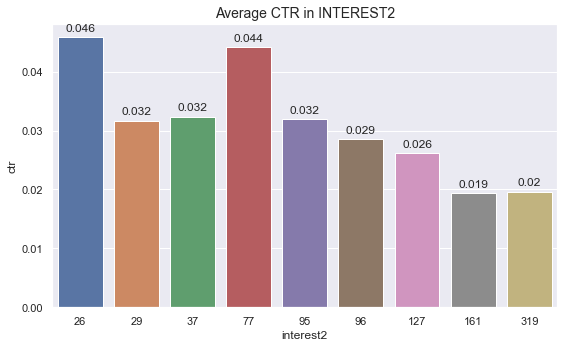

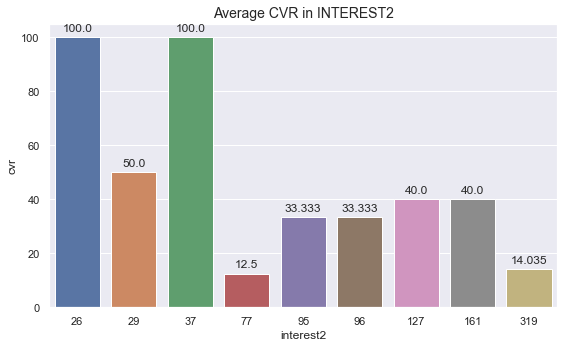

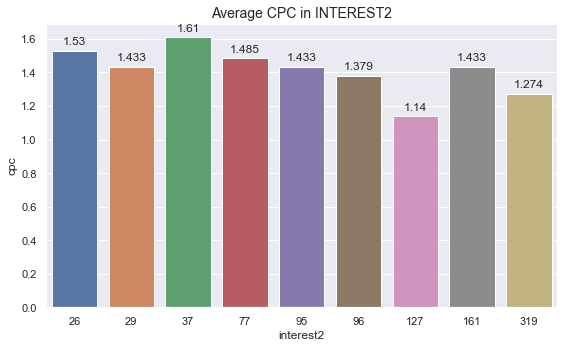

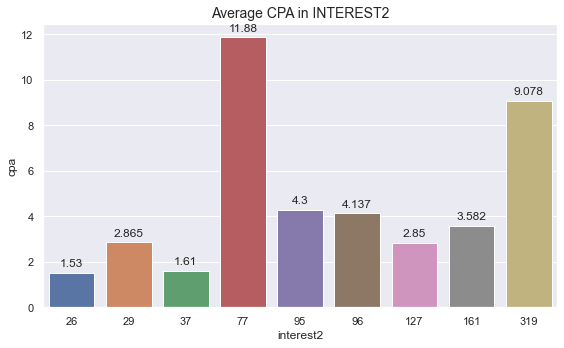

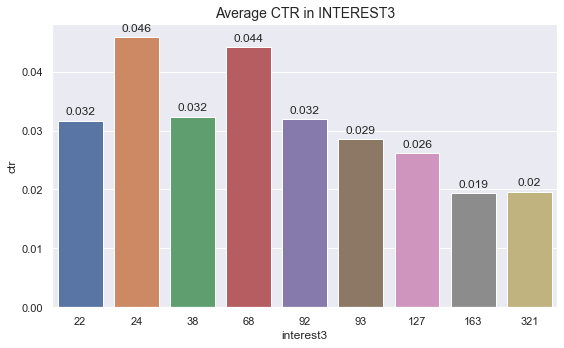

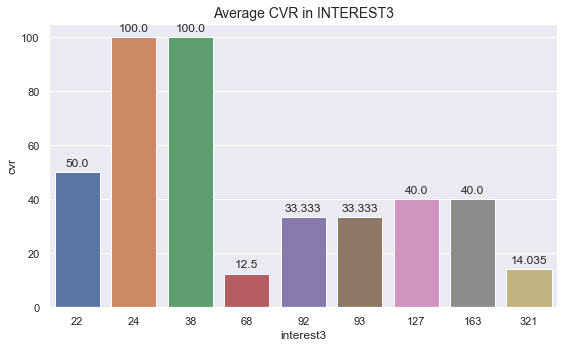

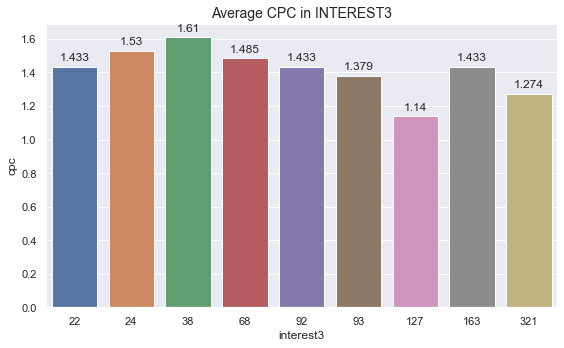

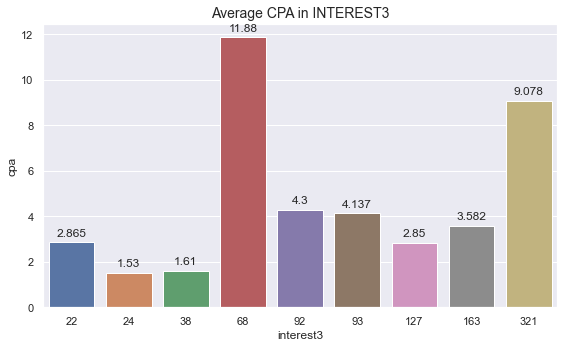

In [23]:
# Checking interests in campaign A

interest_df = df.groupby(['campaign_id', 'interest1']).sum().reset_index()
interest_df = get_metrics(interest_df)
interests = ['interest1', 'interest2', 'interest3']


for interest in interests:
    plot_four(interest_df[interest_df['campaign_id'] == 'campaign_a'], interest, 8,5)

# 2.2 Analyze campaign B

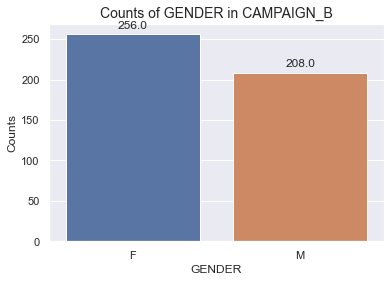

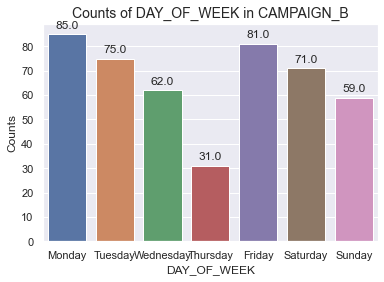

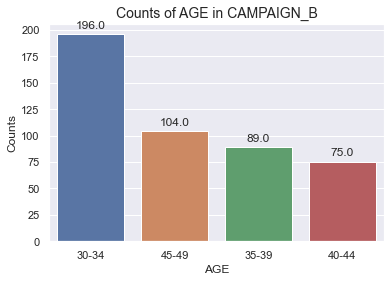

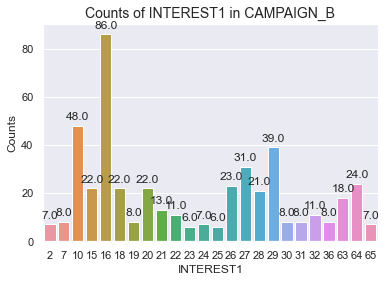

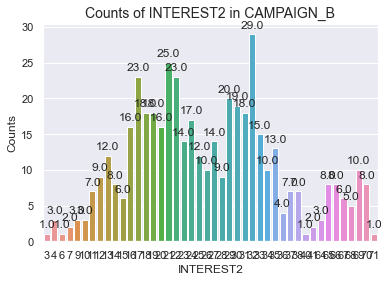

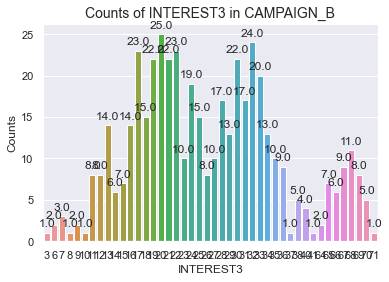

In [24]:
# first examine the distribution in each categorical variables 

factors = ['gender', 'day_of_week', 'age', 'interest1', 'interest2', 'interest3']
for f in factors:
    plot_factor_count(df, 'campaign_b', f)

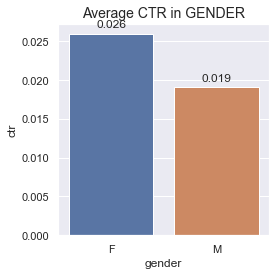

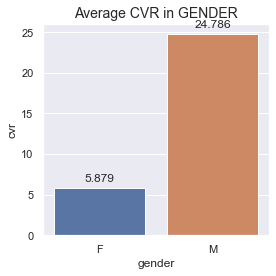

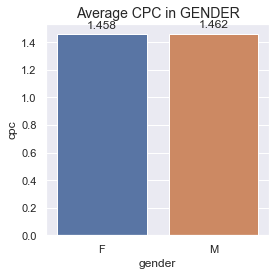

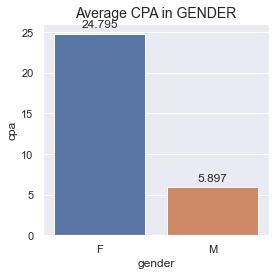

In [25]:
b_gender = df[df['campaign_id'] == 'campaign_b'].groupby(['gender']).sum().reset_index()
b_gender = get_metrics(b_gender)

plot_four(b_gender, 'gender', 4, 4)

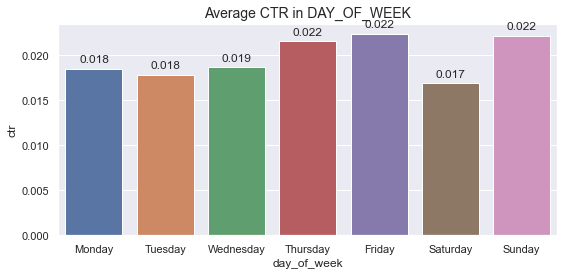

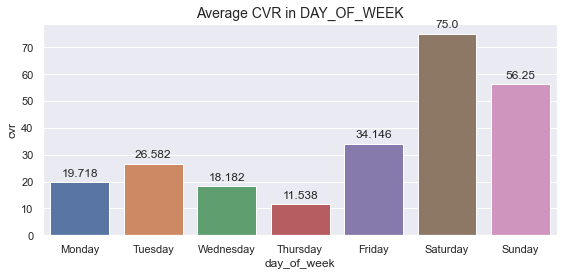

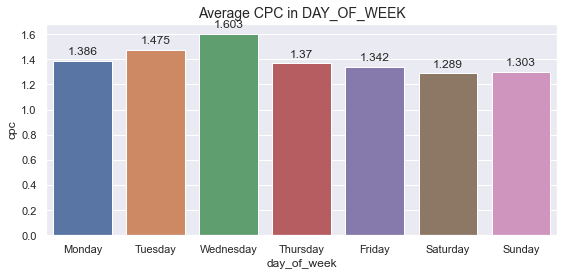

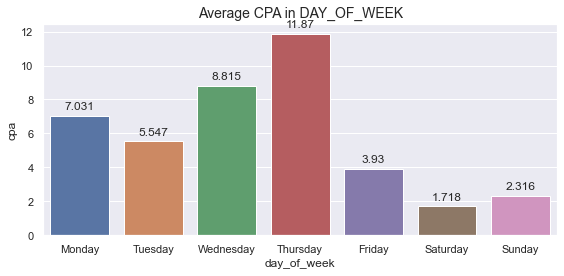

In [26]:
b_week_gender = df[df['campaign_id'] == 'campaign_b'].groupby(['gender', 'day_of_week']).sum().reset_index()
b_week_gender = get_metrics(b_week_gender)

plot_four(b_week_gender[b_week_gender['gender'] =='M'], 'day_of_week', 8, 4)

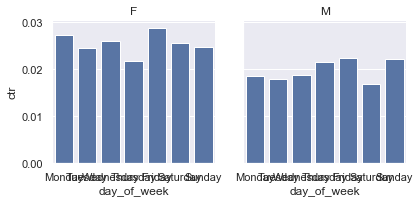

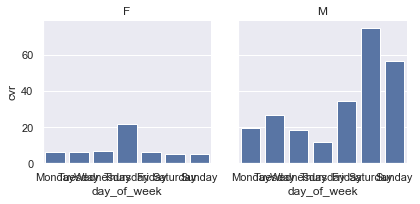

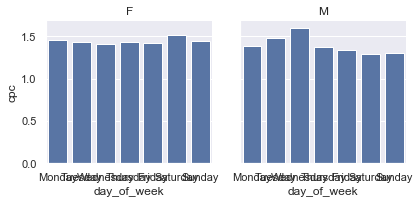

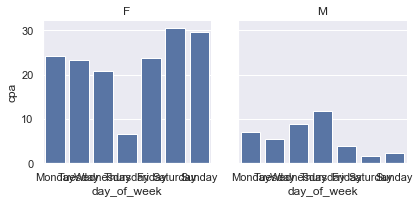

In [27]:
metrics = ['ctr', 'cvr', 'cpc', 'cpa']

for metric in metrics:
    g = sns.FacetGrid(b_week_gender, col = 'gender')
    g.map(sns.barplot, 'day_of_week', metric, 
          order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()

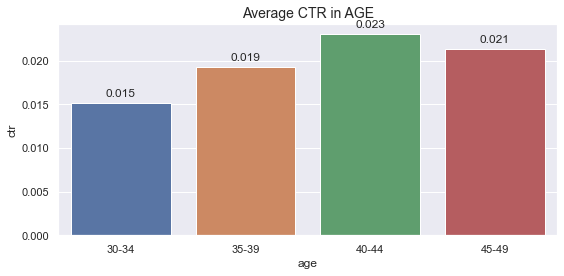

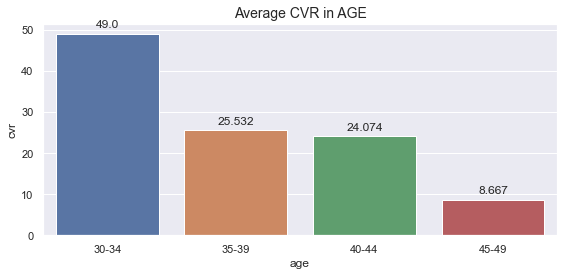

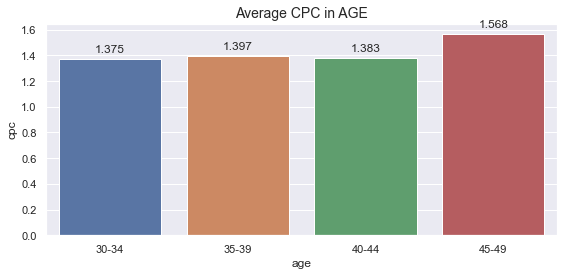

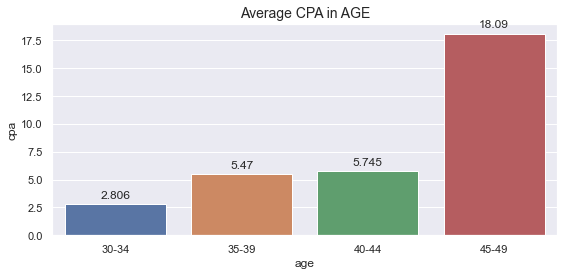

In [28]:
b_age_gender = df[df['campaign_id'] == 'campaign_b'].groupby(['age', 'gender']).sum().reset_index()
b_age_gender = get_metrics(b_age_gender)

plot_four(b_age_gender[b_age_gender['gender'] =='M'], 'age', 8, 4)

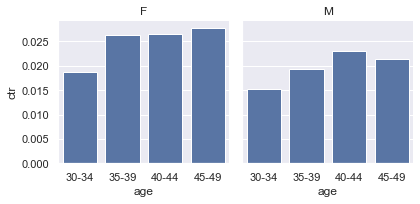

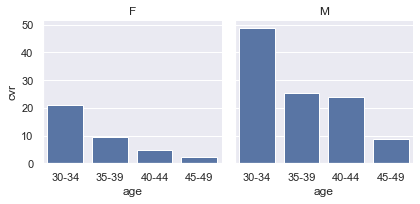

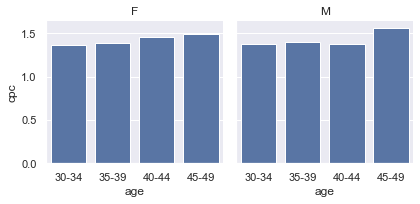

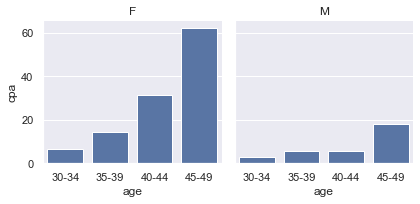

In [29]:
metrics = ['ctr', 'cvr', 'cpc', 'cpa']

for metric in metrics:
    g = sns.FacetGrid(b_age_gender, col = 'gender')
    g.map(sns.barplot, 'age', metric)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()

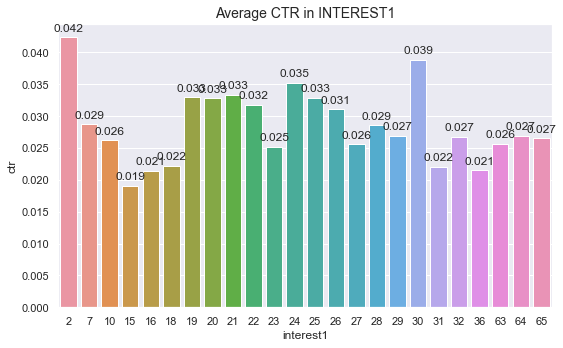

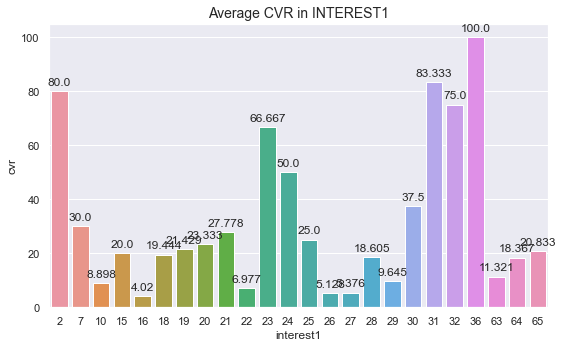

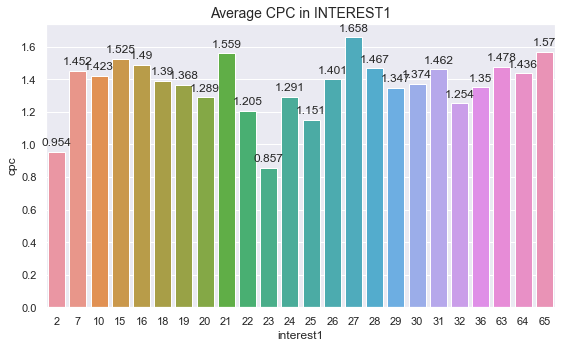

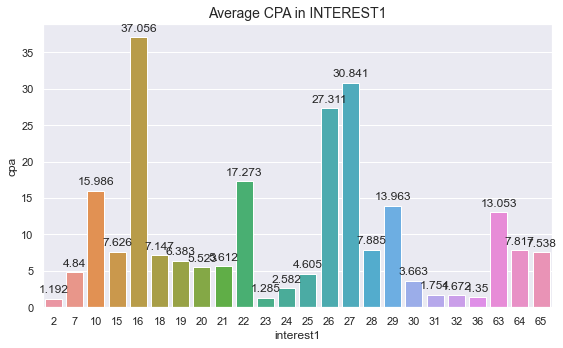

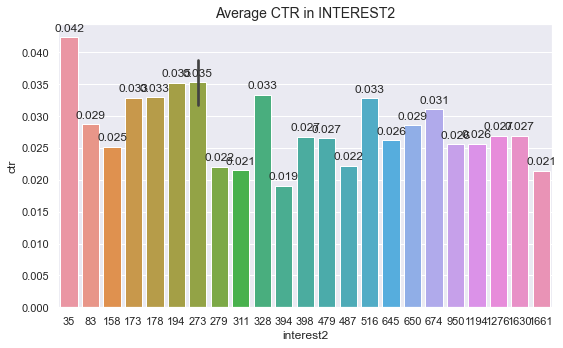

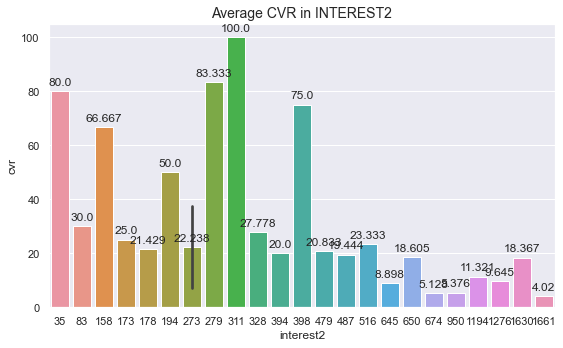

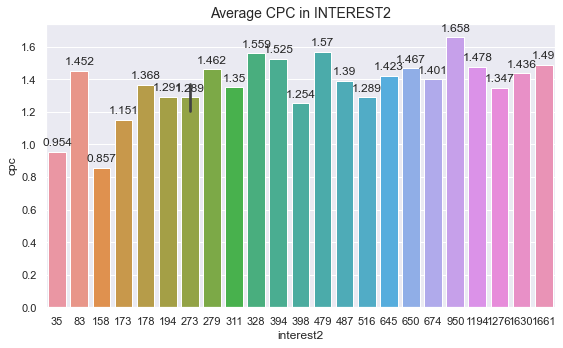

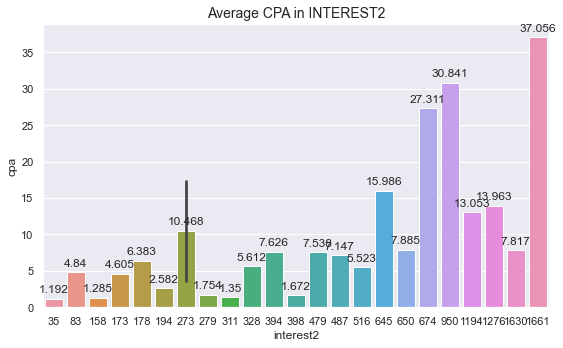

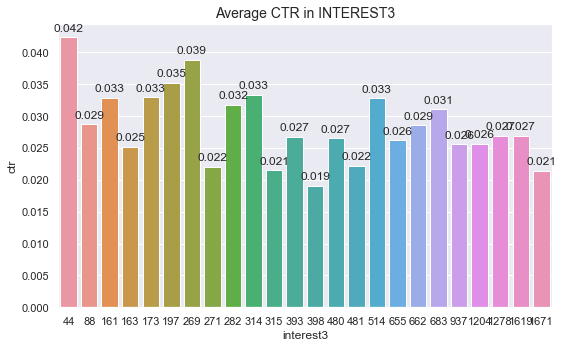

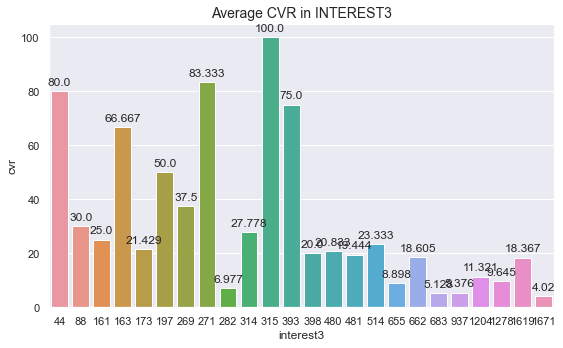

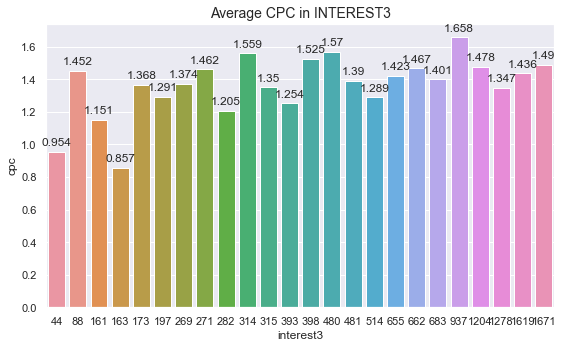

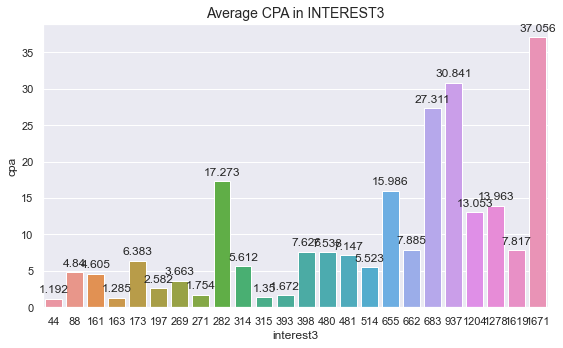

In [30]:
# Checking interests in campaign B

for interest in interests:
    plot_four(interest_df[interest_df['campaign_id'] == 'campaign_b'], interest, 8,5)

Text(0.5, 0, 'Ads Display Time')

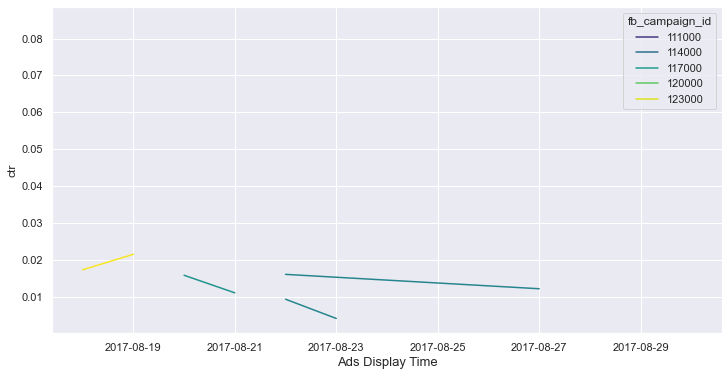

In [31]:
camp_day = df.groupby(['campaign_id', 'fb_campaign_id','reporting_start']).sum().reset_index()
camp_day = get_metrics(camp_day)

ax = plt.figure(figsize=(12, 6))
ax = sns.lineplot(data = camp_day[camp_day['campaign_id'] == 'campaign_b'], 
                  x = 'reporting_start', 
                  y = 'ctr', hue = 'fb_campaign_id', palette = 'viridis')
ax.set_xlabel('Ads Display Time', fontsize=13)

## 1.3 Campaign C

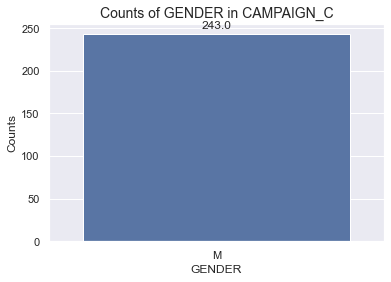

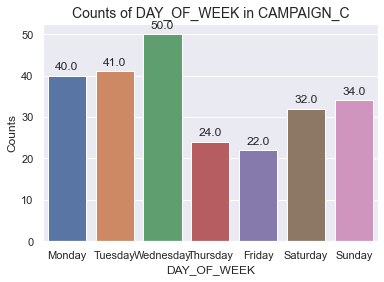

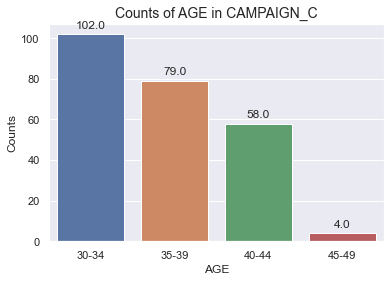

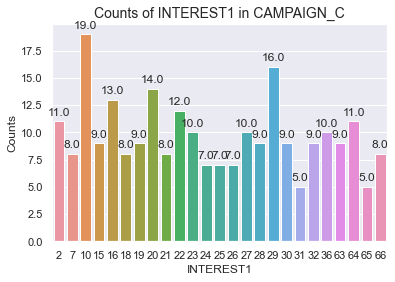

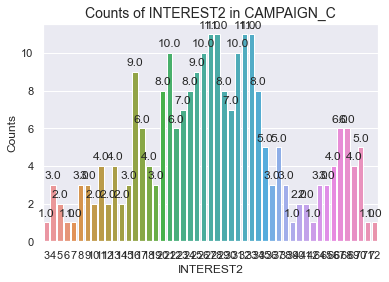

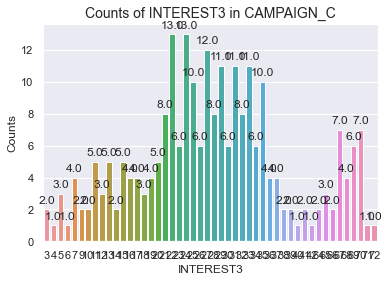

In [32]:
factors = ['gender', 'day_of_week', 'age', 'interest1', 'interest2', 'interest3']
for f in factors:
    plot_factor_count(df, 'campaign_c', f)

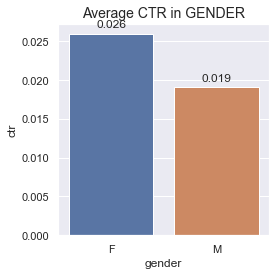

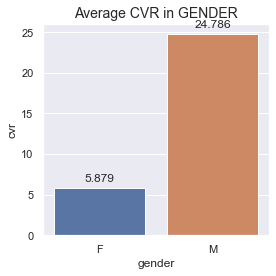

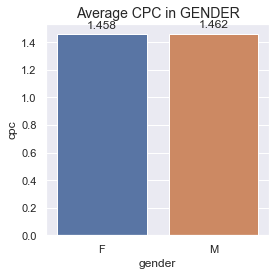

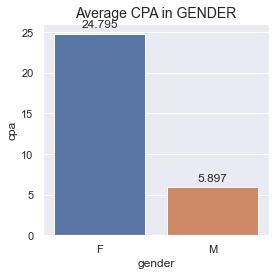

In [33]:
c_gender = df[df['campaign_id'] == 'campaign_b'].groupby(['gender']).sum().reset_index()
c_gender = get_metrics(c_gender)

plot_four(c_gender, 'gender', 4, 4)

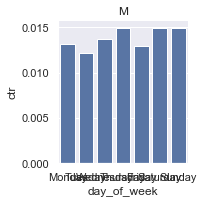

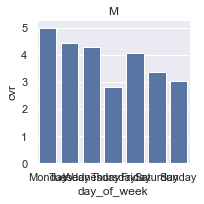

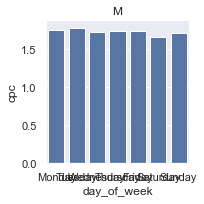

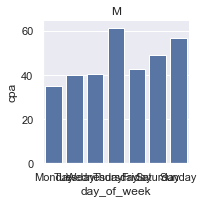

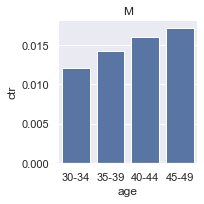

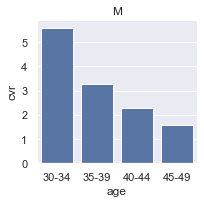

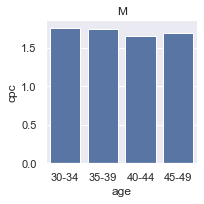

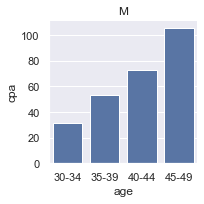

In [34]:
c_week_gender = df[df['campaign_id'] == 'campaign_c'].groupby(['day_of_week', 'gender']).sum().reset_index()
c_week_gender = get_metrics(c_week_gender)

c_age_gender = df[df['campaign_id'] == 'campaign_c'].groupby(['age', 'gender']).sum().reset_index()
c_age_gender = get_metrics(c_age_gender)

metrics = ['ctr', 'cvr', 'cpc', 'cpa']

for metric in metrics:
    g = sns.FacetGrid(c_week_gender, col = 'gender')
    g.map(sns.barplot, 'day_of_week', metric, 
          order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()
    
for metric in metrics:
    g = sns.FacetGrid(c_age_gender, col = 'gender')
    g.map(sns.barplot, 'age', metric)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()

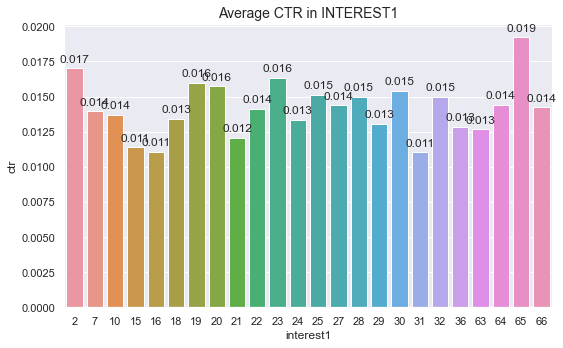

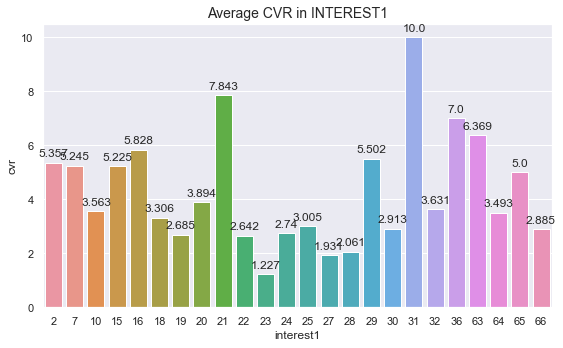

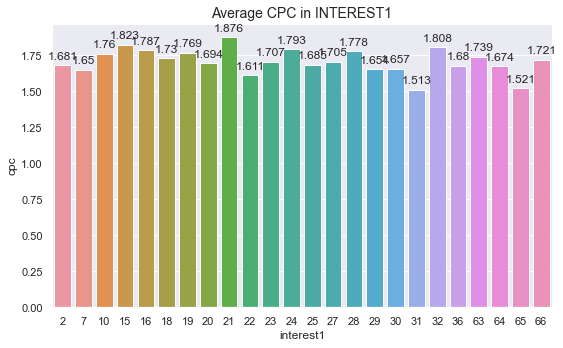

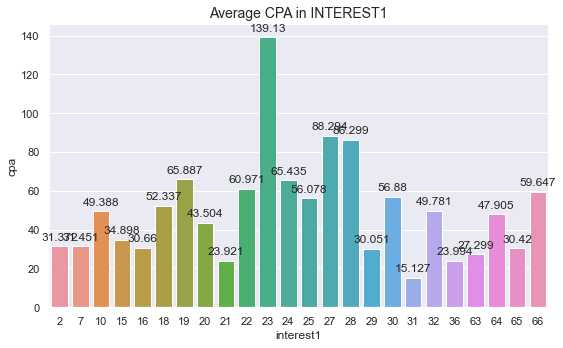

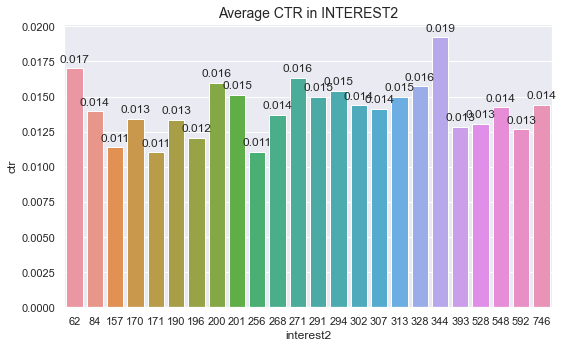

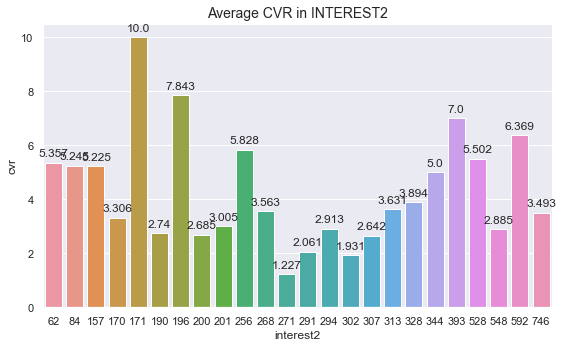

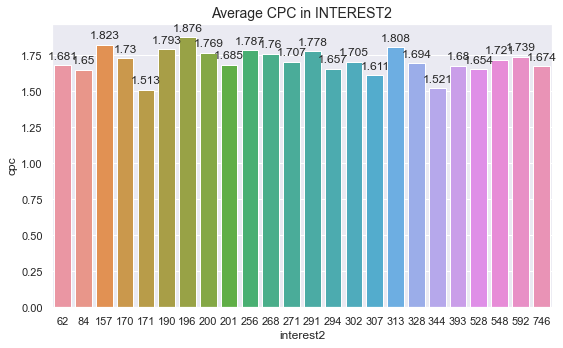

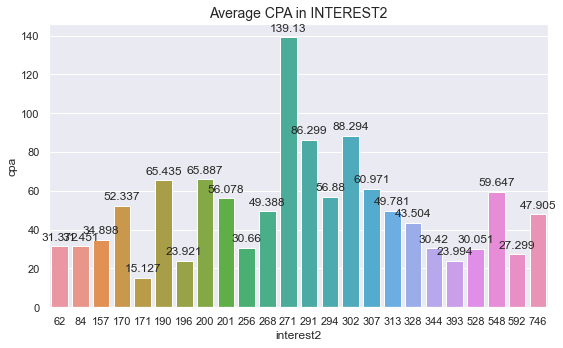

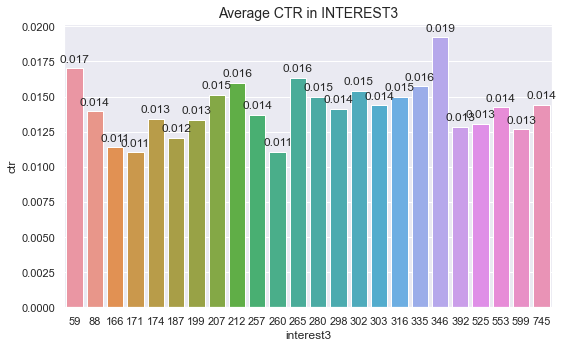

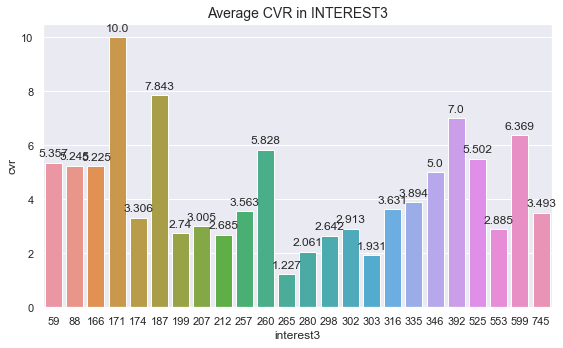

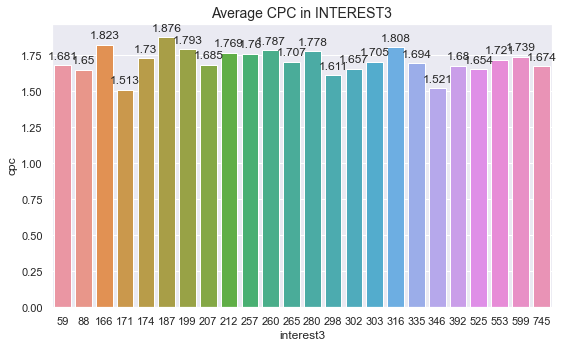

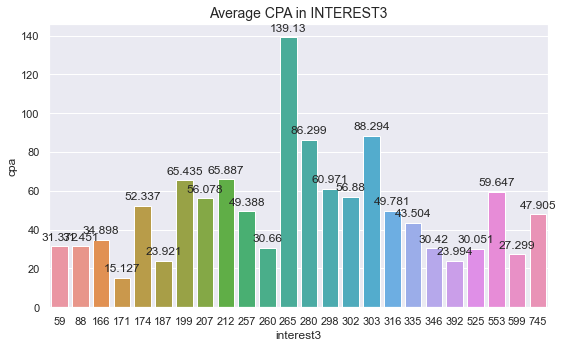

In [35]:
for interest in interests:
    plot_four(interest_df[interest_df['campaign_id'] == 'campaign_c'], interest, 8,5)

Text(0.5, 0, 'Ads Display Time')

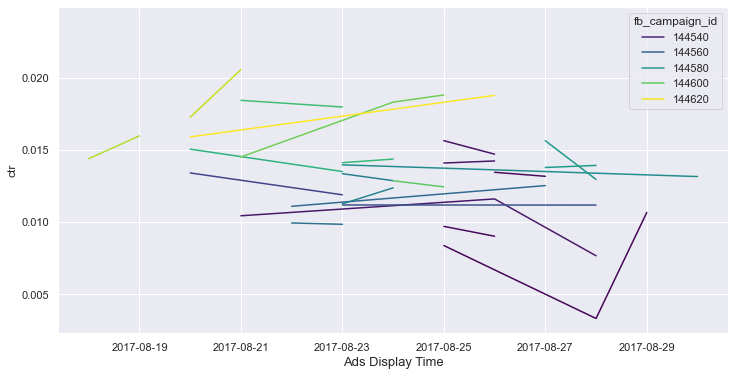

In [36]:
ax = plt.figure(figsize=(12, 6))
ax = sns.lineplot(data = camp_day[camp_day['campaign_id'] == 'campaign_c'], 
                  x = 'reporting_start', 
                  y = 'ctr', hue = 'fb_campaign_id', palette = 'viridis')
ax.set_xlabel('Ads Display Time', fontsize=13)

## 1.4 Campaign D

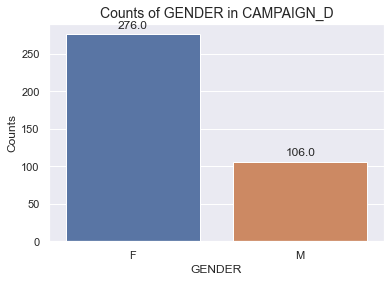

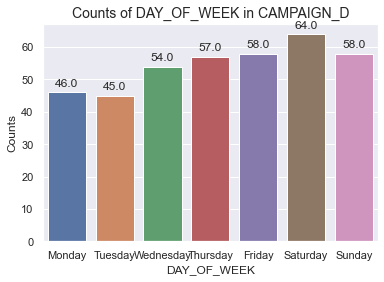

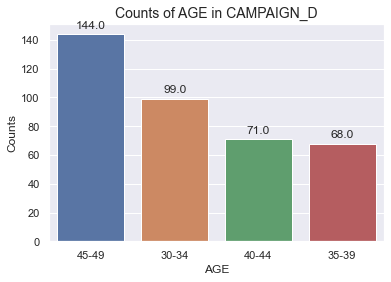

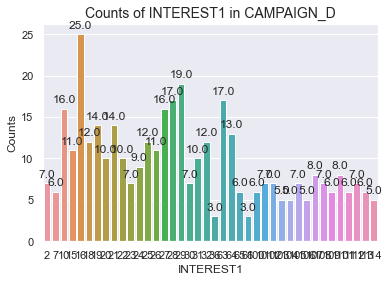

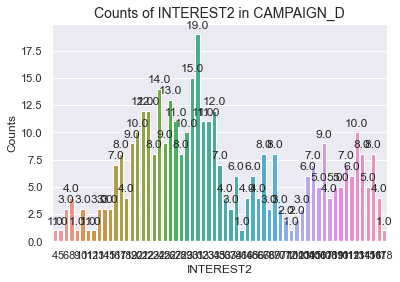

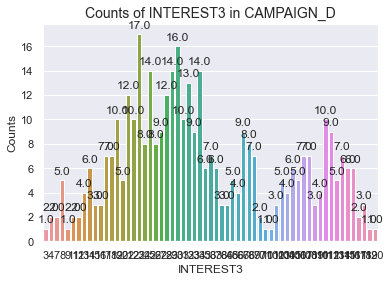

In [37]:
factors = ['gender', 'day_of_week', 'age', 'interest1', 'interest2', 'interest3']
for f in factors:
    plot_factor_count(df, 'campaign_d', f)

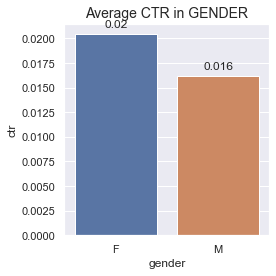

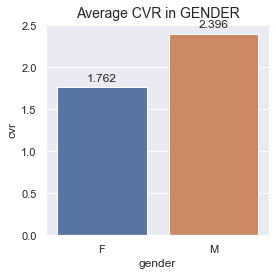

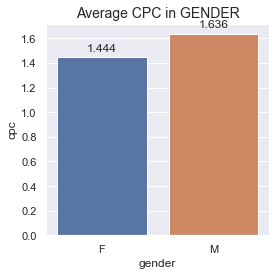

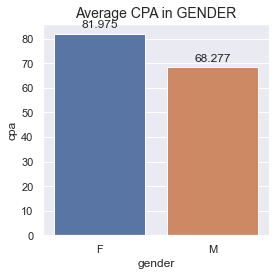

In [38]:
d_gender = df[df['campaign_id'] == 'campaign_d'].groupby(['gender']).sum().reset_index()
d_gender = get_metrics(d_gender)

plot_four(d_gender, 'gender', 4, 4)

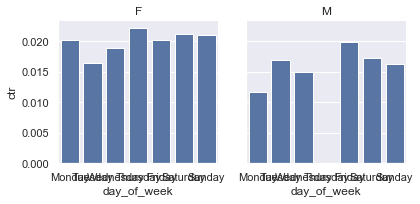

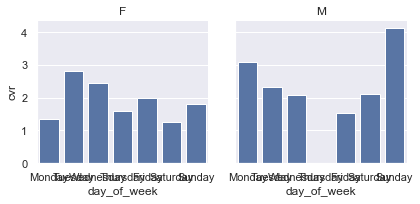

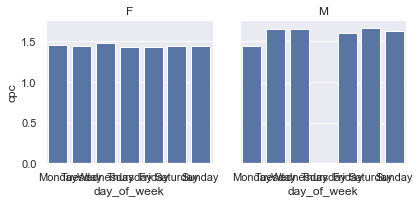

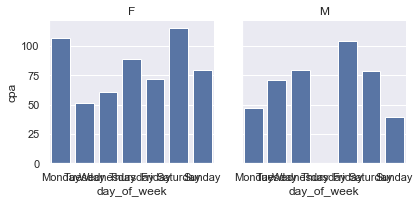

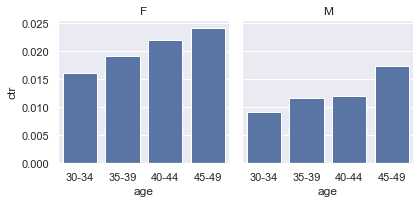

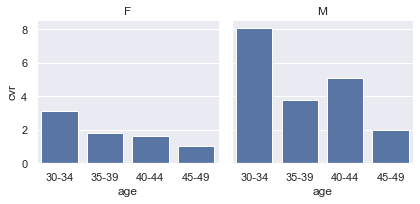

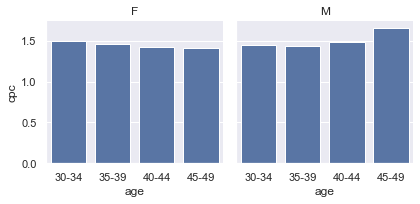

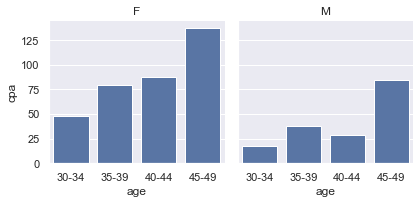

In [39]:
d_week_gender = df[df['campaign_id'] == 'campaign_d'].groupby(['day_of_week', 'gender']).sum().reset_index()
d_week_gender = get_metrics(d_week_gender)

d_age_gender = df[df['campaign_id'] == 'campaign_d'].groupby(['age', 'gender']).sum().reset_index()
d_age_gender = get_metrics(d_age_gender)

metrics = ['ctr', 'cvr', 'cpc', 'cpa']

for metric in metrics:
    g = sns.FacetGrid(d_week_gender, col = 'gender')
    g.map(sns.barplot, 'day_of_week', metric, 
          order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()
    
for metric in metrics:
    g = sns.FacetGrid(d_age_gender, col = 'gender')
    g.map(sns.barplot, 'age', metric)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()